/home/girishkk/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


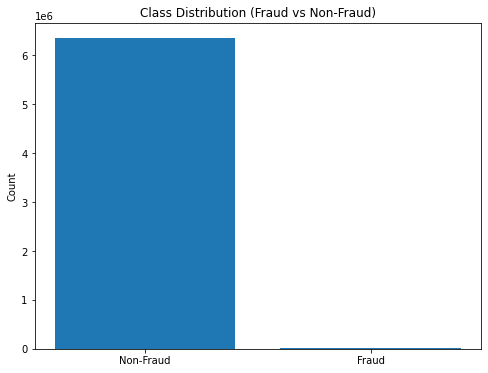

IndexError: index 1279933 is out of bounds for dimension 0 with size 8213

In [1]:
#!/usr/bin/env python
# coding: utf-8

import pandas as pd
import torch
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, r2_score, matthews_corrcoef
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Data preprocessing functions
def df_label_encoder(df, columns):
    """Encode categorical columns using LabelEncoder"""
    le = preprocessing.LabelEncoder()
    for col in columns:
        df[col] = le.fit_transform(df[col].astype(str))
    return df

def preprocess(df):
    """Preprocess the dataset and extract features for node creation"""
    # Encode categorical columns (Adjust the columns according to the PaySim dataset)
    df = df_label_encoder(df, ['type', 'nameOrig', 'nameDest', 'isFraud'])
    
    # Normalize numerical columns (e.g., amount, old balance, new balance)
    df['amount'] = (df['amount'] - df['amount'].min()) / (df['amount'].max() - df['amount'].min())
    df['oldbalanceOrg'] = (df['oldbalanceOrg'] - df['oldbalanceOrg'].min()) / (df['oldbalanceOrg'].max() - df['oldbalanceOrg'].min())
    df['newbalanceOrig'] = (df['newbalanceOrig'] - df['newbalanceOrig'].min()) / (df['newbalanceOrig'].max() - df['newbalanceOrig'].min())
    
    # Create node mappings
    df['node_from'] = df['nameOrig'].astype(str)
    df['node_to'] = df['nameDest'].astype(str)
    df = df.sort_values(by=['node_from'])
    
    # Get unique nodes
    node_list = pd.concat([df['node_from'], df['node_to']]).unique()
    return df, node_list

def create_graph_data(df, node_list):
    """Create graph data structures from DataFrame"""
    # Create node mapping
    node_map = {node: idx for idx, node in enumerate(node_list)}
    
    # Create edge index
    edge_index = np.array([[
        node_map[from_node], node_map[to_node]
    ] for from_node, to_node in zip(df['node_from'], df['node_to'])], dtype=np.int64).T
    
    # Convert to torch tensors
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    node_features = torch.tensor(df[['amount', 'oldbalanceOrg', 'newbalanceOrig']].values, dtype=torch.float)
    labels = torch.tensor(df['isFraud'].values, dtype=torch.long)
    
    return node_features, edge_index, labels

# Model components
class GraphSAGELayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GraphSAGELayer, self).__init__()
        self.fc = nn.Linear(in_features * 2, out_features)
        
    def forward(self, x, edge_index):
        row, col = edge_index
        neighbor_mean = torch.zeros_like(x)
        neighbor_mean.index_add_(0, row, x[col])
        counts = torch.bincount(row, minlength=x.size(0)).view(-1, 1).clamp(min=1)
        neighbor_mean /= counts
        out = torch.cat([x, neighbor_mean], dim=1)
        return torch.relu(self.fc(out))

class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.sage1 = GraphSAGELayer(input_size, hidden_size)
        self.sage2 = GraphSAGELayer(hidden_size, output_size)
        self.final_activation = nn.Sigmoid()

    def forward(self, z, edge_index):
        z = self.sage1(z, edge_index)
        z = self.sage2(z, edge_index)
        return self.final_activation(z)

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Discriminator, self).__init__()
        self.sage1 = GraphSAGELayer(input_size, hidden_size)
        self.sage2 = GraphSAGELayer(hidden_size, 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x, edge_index):
        x = self.sage1(x, edge_index)
        x = self.sage2(x, edge_index)
        return self.final_activation(x)

# Visualization functions
def plot_class_distribution(y_data, title):
    """Plot class distribution histogram"""
    classes, counts = torch.unique(y_data, return_counts=True)
    plt.figure(figsize=(8, 6))
    plt.bar(classes.numpy(), counts.numpy())
    plt.title(title)
    plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
    plt.ylabel('Count')
    plt.show()

def plot_metrics(metrics_history):
    """Plot training metrics over time"""
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(metrics_history['d_loss'], label='Discriminator Loss')
    plt.plot(metrics_history['g_loss'], label='Generator Loss')
    plt.title('Training Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(metrics_history['accuracy'], label='Accuracy')
    plt.plot(metrics_history['auc_roc'], label='AUC-ROC')
    plt.title('Performance Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def evaluate_model(discriminator, node_features, edge_index, labels):
    """Evaluate model performance and print metrics"""
    with torch.no_grad():
        pred_probs = discriminator(node_features, edge_index)
        pred_labels = (pred_probs > 0.5).float()

    # Convert to numpy for metric calculation
    y_true = labels.numpy()
    y_pred = pred_labels.numpy()
    y_prob = pred_probs.numpy()

    # Calculate metrics
    metrics = {
        'AUC-ROC': roc_auc_score(y_true, y_prob),
        'F1 Score': f1_score(y_true, y_pred),
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'R2 Score': r2_score(y_true, y_prob),
        'MCC': matthews_corrcoef(y_true, y_pred)
    }

    # Print metrics
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")

    return metrics

def train_gan(generator, discriminator, node_features, edge_index, labels, 
              num_epochs=10, latent_size=64, batch_size=32):
    """Train the GAN model"""
    
    # Initialize optimizers
    optimizer_g = optim.Adam(generator.parameters(), lr=0.001)
    optimizer_d = optim.Adam(discriminator.parameters(), lr=0.001)
    loss_fn = nn.BCELoss()
    
    # Get real data
    real_data = node_features[labels == 1]
    target_minority_class = torch.sum(labels == 0)
    
    # Training history
    metrics_history = {
        'd_loss': [], 'g_loss': [], 
        'accuracy': [], 'auc_roc': []
    }
    
    for epoch in range(num_epochs):
        current_minority_count = torch.sum(labels == 1)
        if current_minority_count >= target_minority_class:
            break
        
        # Train discriminator
        optimizer_d.zero_grad()
        
        # Real data
        d_real = discriminator(real_data, edge_index)
        real_labels = torch.ones(d_real.shape)
        loss_real = loss_fn(d_real, real_labels)
        
        # Fake data
        z = torch.randn(real_data.size(0), latent_size)
        fake_data = generator(z, edge_index)
        d_fake = discriminator(fake_data.detach(), edge_index)
        fake_labels = torch.zeros(d_fake.shape)
        loss_fake = loss_fn(d_fake, fake_labels)
        
        # Total discriminator loss
        loss_d = loss_real + loss_fake
        loss_d.backward()
        optimizer_d.step()
        
        # Train generator
        optimizer_g.zero_grad()
        d_fake = discriminator(fake_data, edge_index)
        loss_g = loss_fn(d_fake, torch.ones_like(d_fake))
        loss_g.backward()
        optimizer_g.step()
        
        # Update dataset
        with torch.no_grad():
            labels = torch.cat((labels, torch.ones(fake_data.shape[0])))
        
        # Collect metrics
        metrics_history['d_loss'].append(loss_d.item())
        metrics_history['g_loss'].append(loss_g.item())
        
        # Evaluate performance
        metrics = evaluate_model(discriminator, node_features, edge_index, labels)
        metrics_history['accuracy'].append(metrics['Accuracy'])
        metrics_history['auc_roc'].append(metrics['AUC-ROC'])
        
        # Print progress
        print(f"Epoch {epoch + 1}/{num_epochs}, Discriminator Loss: {loss_d.item():.4f}, Generator Loss: {loss_g.item():.4f}")
    
    return metrics_history


if __name__ == "__main__":
    # Load and preprocess the PaySim dataset (replace with actual dataset path)
    df = pd.read_csv('paysim/paysim.csv')
    
    # Preprocess dataset and split into training/test sets
    df, node_list = preprocess(df)
    node_features, edge_index, labels = create_graph_data(df, node_list)
    
    # Visualize class distribution
    plot_class_distribution(labels, 'Class Distribution (Fraud vs Non-Fraud)')
    
    # Initialize models
    generator = Generator(input_size=node_features.size(1), hidden_size=128, output_size=node_features.size(1))
    discriminator = Discriminator(input_size=node_features.size(1), hidden_size=128)
    
    # Train GAN model
    metrics_history = train_gan(generator, discriminator, node_features, edge_index, labels, num_epochs=20)
    
    # Plot training metrics
    plot_metrics(metrics_history)
